# AWS Sagemaker Dog Breed Classification

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [33]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [65]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker

import IPython
import os
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

import sagemaker
import boto3

import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np


from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch


# import modules for debugging, profiling
from sagemaker.debugger import Rule, ProfilerRule, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, rule_configs

# import modules for hyperparameter tuning
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [35]:
#TODO: Fetch and upload the data to AWS S3
# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

# sync data to s3
# !aws s3 sync dogImages/ s3://dog-breed-image-classifier/

In [36]:
# bucket name to keep projec data
role = get_execution_role()
bucket = 'dog-breed-image-classifier'
input_data = f's3://{bucket}'

print('Sagemaker execution role: ', role)
print(f'Training Input data is located at: {input_data}')

Sagemaker execution role:  arn:aws:iam::624558554882:role/service-role/AmazonSageMaker-ExecutionRole-20221219T103433
Training Input data is located at: s3://dog-breed-image-classifier


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#TODO: Declare your HP ranges, metrics etc.
hyperparamater_ranges = {
    # 'arch': CategoricalParameter(['densenet121', 'resnet18']),
    'epochs': IntegerParameter(5, 10),
    'lr': ContinuousParameter(1e-5, 0.1),
    'dropout_rate': CategoricalParameter([0.2, 0.4]),
    'hidden_units': CategoricalParameter([256, 384, 512, 640]),    
    'batch_size': CategoricalParameter([16, 32, 64]),
    'test_batch_size': CategoricalParameter([16, 32, 64]),
}

In [7]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point='hpo.py',
    role = role,
    base_job_name = 'dog-bre-ic-exp-1',
    instance_type = 'ml.g4dn.xlarge',  #-->'ml.m5.xlarge', g4dn
    instance_count =1,
    framework_version = '1.12',
    py_version = 'py38',
)


objective_metric_name = 'validation accuracy'
objective_type = 'Maximize'
metric_definitions =  [{
    "Name": "validation accuracy",
    "Regex": "valid accuracy: ([0-9\\.]+)"}]   # fetch name from valid log/print in train func


tuner = HyperparameterTuner(
    estimator = estimator,
    base_tuning_job_name = 'dog-bre-tuning-exp-1',
    objective_metric_name = objective_metric_name,
    hyperparameter_ranges = hyperparamater_ranges,
    metric_definitions = metric_definitions,
    max_jobs = 4,
    max_parallel_jobs = 2,
    objective_type = objective_type,
    # early_stopping_type= 'Auto'
)

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({'training': input_data}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................................................................................................................................................................................................................................

In [12]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()


2023-03-05 16:01:43 Starting - Preparing the instances for training
2023-03-05 16:01:43 Downloading - Downloading input data
2023-03-05 16:01:43 Training - Training image download completed. Training in progress.
2023-03-05 16:01:43 Uploading - Uploading generated training model
2023-03-05 16:01:43 Completed - Resource reused by training job: dog-bre-tuning-exp-1-230305-1540-004-4ef93769


In [13]:
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"validation accuracy"',
 'batch_size': '"64"',
 'dropout_rate': '"0.4"',
 'epochs': '10',
 'hidden_units': '"512"',
 'lr': '0.00041344049002957486',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-bre-ic-exp-1-2023-03-05-15-40-51-970"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-037495207244/dog-bre-ic-exp-1-2023-03-05-15-40-51-970/source/sourcedir.tar.gz"',
 'test_batch_size': '"64"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
best_hyperparameters = dict()

for key, val in best_estimator.hyperparameters().items():
    if key in ['arch', 'batch_size', 'test_batch_size', 'dropout_rate', 'epochs', 'hidden_units', 'lr']:
        best_hyperparameters[key] = val 
        
best_hyperparameters

{'batch_size': '"64"',
 'dropout_rate': '"0.4"',
 'epochs': '10',
 'hidden_units': '"512"',
 'lr': '0.00041344049002957486',
 'test_batch_size': '"64"'}

```python
##  exp 1
{'arch': '"resnet18"',
 'batch_size': '"64"',
 'dropout_rate': '"0.65"',
 'epochs': '12',
 'hidden_units': '"640"',
 'lr': '0.023931905932654127',
 'test_batch_size': '"16"'}

# exp 2
{'arch': '"resnet18"',
 'batch_size': '"128"',
 'dropout_rate': '"0.65"',
 'epochs': '19',
 'hidden_units': '"256"',
 'lr': '0.001720067698389021',
 'test_batch_size': '"64"'}

# exp 3
{'batch_size': '"128"',
 'dropout_rate': '"0.2"',
 'epochs': '9',
 'hidden_units': '"640"',
 'lr': '0.0021406024008438643',
 'test_batch_size': '"16"'}
 
 # exp 4
 {'batch_size': '"64"',
 'dropout_rate': '"0.4"',
 'epochs': '10',
 'hidden_units': '"512"',
 'lr': '0.00041344049002957486',
 'test_batch_size': '"64"'}
 ```


In [53]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    ProfilerRule.sagemaker(rule_configs.CPUBottleneck()),

]

hook_config = DebuggerHookConfig(
    hook_parameters={
        'train.save_interval':'10',
        'eval.save_interval': '1'
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis = 500,
    framework_profile_params = FrameworkProfile(num_steps=10)
)


hyper_dict = {
    'batch_size': '"64"',
    'dropout_rate': '"0.4"',
    'epochs': '1',
    'hidden_units': '"512"',
    'lr': '0.00041344049002957486',
    'test_batch_size': '"64"'
}

In [54]:
# configuring estimator using best HPO
best_estimator = PyTorch(
    entry_point='train_model.py',
    role = role,
    instance_type = 'ml.m5.2xlarge', # g4dn
    instance_count =1,
    framework_version = '1.12',
    py_version = 'py38',
    # hyperparameters = best_hyperparameters,
    hyperparameters = hyper_dict,    
    # create hook config and profiler
    rules = rules,
    debugger_hook_config = hook_config,
    profiler_config = profiler_config    
)

In [55]:
best_estimator.fit({'training': input_data}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framewo

2023-03-16 13:09:00 Starting - Starting the training job...
2023-03-16 13:09:29 Starting - Preparing the instances for trainingOverfit: InProgress
LossNotDecreasing: InProgress
VanishingGradient: InProgress
PoorWeightInitialization: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
CPUBottleneck: InProgress
...
2023-03-16 13:10:01 Downloading - Downloading input data.........
2023-03-16 13:11:30 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-16 13:11:18,371 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-16 13:11:18,373 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-16 13:11:18,375 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-03-16 13:11:18,385 sagemaker_pytorch_c

In [51]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

print('fetch path to the path to debugger artifact: ')
trial = create_trial(best_estimator.latest_job_debugger_artifacts_path())


fetch path to the path to debugger artifact: 
[2023-03-16 05:55:05.275 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:37 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-624558554882/pytorch-training-2023-03-16-05-55-04-053/debug-output
[2023-03-16 05:55:25.785 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:37 WARNING trial.py:147] Waiting to read collections files generated by the training job,from s3://sagemaker-us-east-1-624558554882/pytorch-training-2023-03-16-05-55-04-053/debug-output/. If this has been a while, you might want to check that the trial is pointed at the right path.
[2023-03-16 05:55:27.821 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:37 WARNING trial.py:147] Waiting to read collections files generated by the training job,from s3://sagemaker-us-east-1-624558554882/pytorch-training-2023-03-16-05-55-04-053/debug-output/. If this has been a while, you might want to check that the trial 

In [34]:
print('Detecting tensors to plot: List all tensors that were recorded: ')
trial.tensor_names()

Detecting tensors to plot: List all tensors that were recorded: 
[2023-03-05 17:25:49.818 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:27 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-03-05 17:25:50.868 pytorch-1-12-cpu-py38-ml-t3-medium-f8be1a063b37f44eb7b009d8cbea:27 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'features.transition1.relu_input_0',
 'features.transition2.relu_input_0',
 'features.transition3.relu_input_0',
 'gradient/DenseNet_classifier.0.bias',
 'gradient/DenseNet_classifier.0.weight',
 'gradient/DenseNet_classifier.3.bias',
 'gradient/DenseNet_classifier.3.weight']

In [35]:
print('Print the numner os steps saved in the dofferent training phase: ')
len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN))

Print the numner os steps saved in the dofferent training phase: 


3

In [36]:
len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL))

1

In [37]:
# functions to log and plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


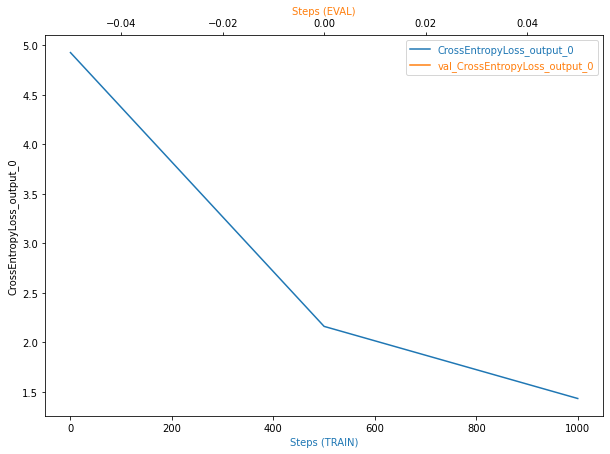

In [38]:
# plotingloss and accuracy curves of training and validation loops.
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

```
    Overfit: InProgress
    LossNotDecreasing: InProgress
    VanishingGradient: InProgress
    PoorWeightInitialization: IssuesFound
    LowGPUUtilization: IssuesFound
    ProfilerReport: InProgress
```

Based on the rule evaluation and the plot above, we candeduce that the trainig job has a poor weight initialization issue.


In [39]:
# Display the profiler output
rule_output_path = best_estimator.output_path + best_estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report in {rule_output_path}")

Profiler report in s3://sagemaker-us-east-1-037495207244/pytorch-training-2023-03-05-17-05-18-992/rule-output


In [40]:
! aws s3 ls {rule_output_path} --recursive

2023-03-05 17:24:33     395552 pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-05 17:24:33     247131 pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-05 17:24:28        192 pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-05 17:24:28      24310 pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-05 17:24:28       1982 pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-05 17:24:28        331 pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-05 17:24:28        425 pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-re

In [41]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-037495207244/pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-037495207244/pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-037495207244/pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-037495207244/pytorch-training-2023-03-05-17-05-18-992/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east

In [42]:
# Get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in best_estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
# Diplay profiler report
# IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [62]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer


model_deploy = PyTorchModel(
    entry_point = 'inference.py',
    role = role,
    model_data = best_estimator.model_data,
    # model_data = ' ',
    framework_version = '1.12',
    py_version = 'py38',
)

In [63]:
# Deploy your model to an endpoint
predictor = model_deploy.deploy(
    instance_type='ml.m5.xlarge', # ml.m5.large
    initial_instance_count=1,
    serializer = IdentitySerializer("image/jpg"),
    deserializer = JSONDeserializer(),
)

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-16-14-16-02-305
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-16-14-16-03-256
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-16-14-16-03-256


------!

prediction: 021.Belgian_sheepdog, probability:  0.0128


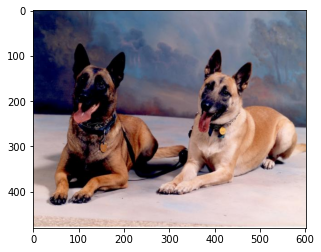

In [ ]:
from train_model import create_data_loaders

# fetch test set batch
data, _ = create_data_loaders('dogImages', 8)

# get cglasses
test_classes = {v: k for k, v in data['test'].dataset.class_to_idx.items()}
# print(test_classes)

image_path = 'dogImages/test/020.Belgian_malinois/Belgian_malinois_01472.jpg'

with open(image_path, 'rb') as img:
    payload = img.read()

response = predictor.predict(payload)
idx = torch.argmax(torch.tensor(response), 1)
predict_class = test_classes.get(idx.item())

probs = torch.nn.functional.softmax(torch.tensor(response), 1).squeeze()
pred_prob = probs[idx.item()]

preview = Image.open(image_path)
plt.imshow(preview)


print(f"prediction: {predict_class}, probability: {pred_prob: .4f}")

In [68]:
# # Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-16-14-16-03-256
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-16-14-16-03-256


In [69]:
# deploy method 2
predictor = best_estimator.deploy(instance_type='ml.m5.large', initial_instance_count=1)

INFO:sagemaker:Creating model with name: pytorch-training-2023-03-16-14-52-12-479
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-03-16-14-52-12-479
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-03-16-14-52-12-479


-----!

In [ ]:
from train_model import create_data_loaders

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

data, num_cls = create_data_loaders('dogImages', 8)
classes = data['test'].dataset.classes
# print(classes, end='\n\n\n')

test_classes = {v: k for k, v in data['test'].dataset.class_to_idx.items()}
# print(test_classes)

# get some test images
dataiter = iter(data['test'])
images, labels = dataiter.next()

# print(images)
# print(labels)

# img = np.array(images)
# img = np.transpose(img, (1, 2, 0))
# img_tensor = torch.tensor(img).float()


imshow(torchvision.utils.make_grid(images))
# imshow(torchvision.utils.make_grid(img_tensor))
print("GroundTruth: ", " ".join("%4s" % classes[labels[j]] for j in range(4)))

outputs = predictor.predict(images.numpy())
# outputs = predictor.predict(img_tensor)


_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)
print("Predicted: ", " ".join("%4s" % classes[predicted[j]] for j in range(4)))